# Libraries

In [2]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import cv2 as cv
import radiomics
from radiomics import featureextractor
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
subfolder_path = Path.cwd()
notebooks_path = subfolder_path.parent
repo_path = notebooks_path.parent
os.chdir(str(subfolder_path))
#print current working directory
print(f'Current folder is: {os.getcwd()}\n')
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent.parent)) if sys.path[0] != str(thispath.parent.parent) else None

#Import paths and patients classes
from notebooks.info import path_label, patient
import notebooks.utils as utils

Current folder is: /home/ricardino/Documents/MAIA/tercer_semestre/Extra_activities/INCan/Added_value_feature_uncertainty/notebooks/budget



# IMP

## Visualize

Patient number is 2



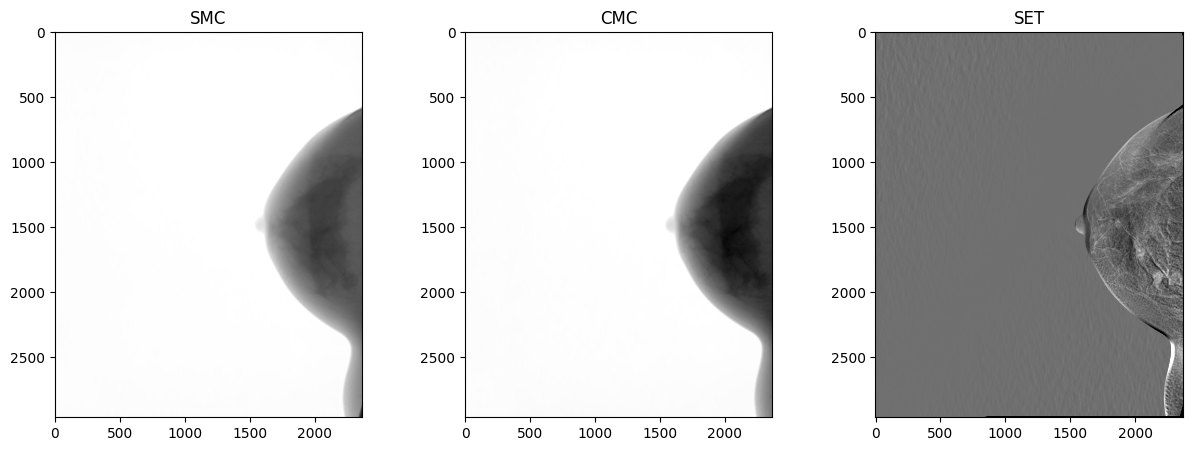

In [7]:
info = path_label()
i = 0
pat = patient(info, i)
print(f'Patient number is {pat.pat_num}\n')
# visualize image with SMC, image at time 1 and SET.
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].set_title('SMC')
axs[0].imshow(pat.im_array(sequence='SMC'), cmap='gray')
axs[1].set_title('CMC')
axs[1].imshow(pat.im_array(sequence='CMC'), cmap='gray')
axs[2].set_title('SET')
axs[2].imshow(pat.im_array(sequence='SET'), vmin = 32671, vmax =32893, cmap='gray')

### Check histograms

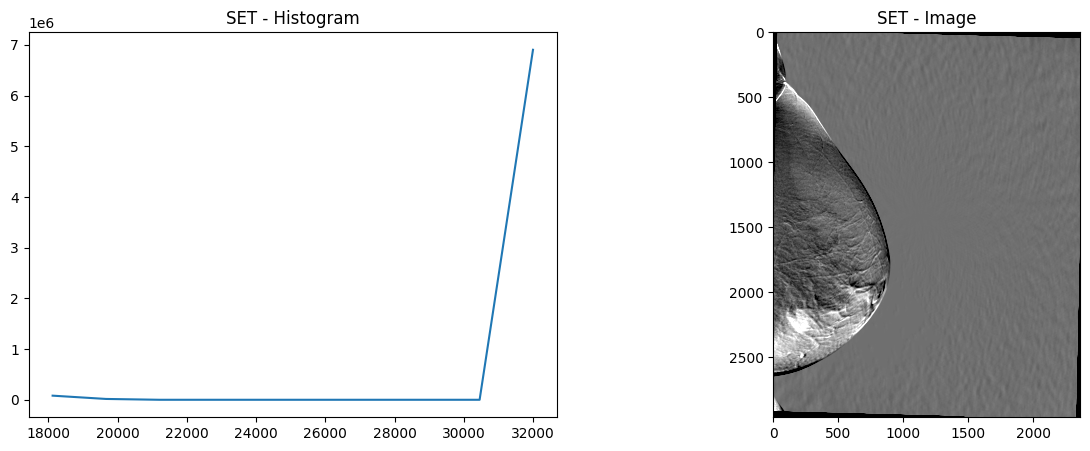

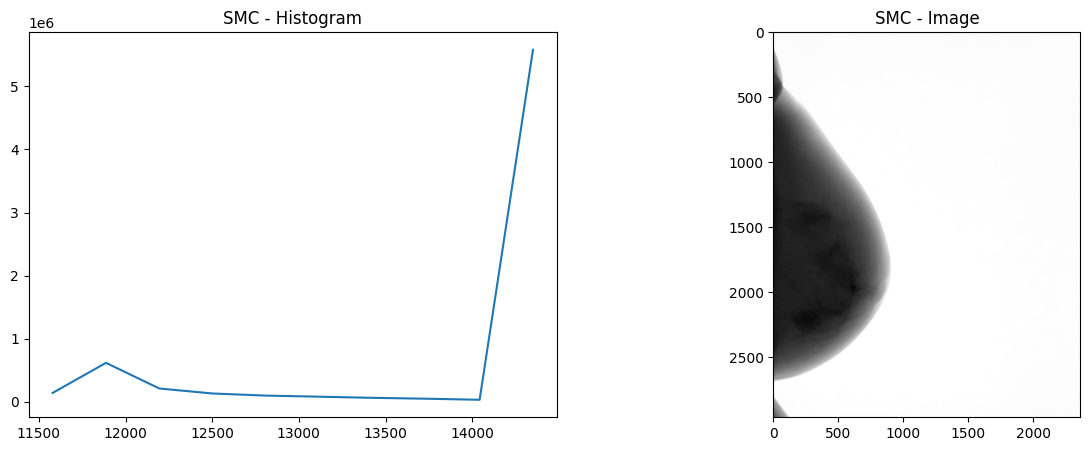

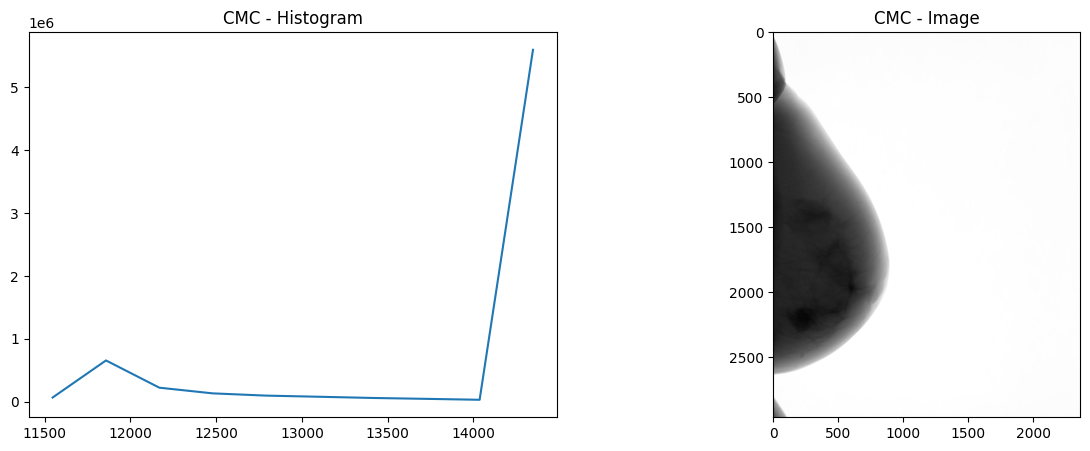

In [5]:
# We check the histograms of each image sequence
for seq in ['SET','SMC', 'CMC']:
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    axs[0].set_title(f'{seq} - Histogram')
    hist = np.histogram(pat.im_array(sequence=seq))
    axs[0].plot(hist[1][:-1], hist[0])
    axs[1].set_title(f'{seq} - Image')
    axs[1].imshow(pat.im_array(sequence=seq), cmap='gray') if seq != 'SET' else axs[1].imshow(pat.im_array(sequence=seq), vmin = 32671, vmax =32893, cmap='gray')

## Cheking image substractions

Images precontrast (SMC) and post contrast (CMC) are not originally registered. <br/>
First, we check some information about each image.

In [6]:
info = path_label() #create object with all patients info
pat = patient(info, num=1) #use only patient 0

print(f'Patient number: {pat.pat_num}')

#Print dtype of images and min max values
print(f'The dtype of the images is\n CMC: {pat.im_array(sequence="CMC").dtype}\n SMC: {pat.im_array(sequence="SMC").dtype}\n SET: {pat.im_array(sequence="SET").dtype}')
print(f'The min and max values of the images are\n CMC: {pat.im_array(sequence="CMC").min(), pat.im_array(sequence="CMC").max()}\n SMC: {pat.im_array(sequence="SMC").min(), pat.im_array(sequence="SMC").max()}\n SET: {pat.im_array(sequence="SET").min(), pat.im_array(sequence="SET").max()}')
print(f'The size of the image are\n CMC: {pat.im_array(sequence="CMC").shape}\n SMC: {pat.im_array(sequence="SMC").shape}\n SET: {pat.im_array(sequence="SET").shape}')
print(f'The ranges of the images are\n CMC: {pat.im_array(sequence="CMC").ptp()}\n SMC: {pat.im_array(sequence="SMC").ptp()}\n SET: {pat.im_array(sequence="SET").ptp()}')
#Get images
im_SMC = pat.im_array(sequence='SMC')
im_CMC = pat.im_array(sequence='CMC')
im_SET = pat.im_array(sequence='SET')
#substract
im_substraction = -(im_CMC.astype(np.int32) - im_SMC.astype(np.int32))
#shift intensities to be uint16
im_substraction = (im_substraction - im_substraction.min()).astype(np.uint16) #save with original dtype
utils.min_max(im_substraction, show=True)
#save image as tiff using SET as reference
utils.save_as_nifti(im_substraction, filename=str(repo_path / f'data/substracted_images/Pat_{pat.pat_num}_CMC-SMC.tif'), reference_path=str(repo_path / pat.im_path('SET', 't1')[0]))

Patient number: 3
The dtype of the images is
 CMC: uint16
 SMC: uint16
 SET: uint16
The min and max values of the images are
 CMC: (11546, 14659)
 SMC: (11579, 14659)
 SET: (18120, 33537)
The size of the image are
 CMC: (2964, 2364)
 SMC: (2964, 2364)
 SET: (2964, 2364)
The ranges of the images are
 CMC: 3113
 SMC: 3080
 SET: 15417
Min: 0, Max: 3649


## New budget pipeline

Assume he images are already registered

### Functions

In [6]:
def substract(im_base, im_restant, sitk_im=False, reference_path=None, save=False):
    """given base and restant images, substract restant from base and return the result
    Minimum value of substraction is shifted to 0 to become uint16 image

    Args:
        im_base (array): base image
        im_restant (array): restant image
        sitk_im (bool, optional): if True, the image is a sitk obj using SET as reference image. Defaults to False.
        reference_path (str, optional): path to SET reference image. Defaults to None.

    Returns:
        array or sitk image: uint16 image with the substraction
    """
    #Subsract using im_base as reference and transform to int32 for negative values
    im_substraction = (im_base.astype(np.int32) - im_restant.astype(np.int32))
    #shift intensities to be uint16
    im_substraction = (im_substraction + 33152).astype(np.uint16) #save with original dtype
    utils.min_max(im_substraction, show=True)

    if save:
        utils.save_as_nifti(im_substraction, filename=str(repo_path / f'data/substracted_images/Pat_{pat.pat_num}_CMC-SMC_x{x_trans}_y{y_trans}.tif'), reference_path=str(repo_path / pat.im_path('SET', 't1')[0]))
    if sitk_im: #in case of sitk image
        reference_image = sitk.ReadImage(reference_path)
        im_substraction = sitk.GetImageFromArray(im_substraction)
        im_substraction.SetOrigin(reference_image.GetOrigin())
        im_substraction.SetSpacing(reference_image.GetSpacing())
        im_substraction.SetDirection(reference_image.GetDirection())
        return im_substraction
    #else return array
    return im_substraction

def extractor_settings(param_path, show=False):
    """set extraction settings for pyradiomics

    Args:
        param_path (str): relative path of parameter file
        show (bool, optional): if printing setting or not. Defaults to False.

    Returns:
        obj: extractor of pyradiomics
    """
    extractor = featureextractor.RadiomicsFeatureExtractor(str(repo_path /param_path))
    if show:
        print('Extraction parameters:\n\t', extractor.settings)
        print('Enabled filters:\n\t', extractor.enabledImagetypes)
        print('Enabled features:\n\t', extractor.enabledFeatures)
    return extractor

In [7]:
def substraction_features(df, im_base, im_restant, pat, rad='L', time='1', stype='G', save_im=False):
    """iterative function to extract features from substracted images

    Args:
        df (dataframe): dataframe to store all features vectors
        im_base (array): base image
        im_restant (array): image to substract from base
        pat (obj): patient object
        rad (str, optional): radiologist. Defaults to 'L'.
        time (str, optional): segmentation time. Defaults to '1'.
        stype (str, optional): segmentation type. Defaults to 'G'.
        save_im (bool, optional): save substraction image or not. Defaults to False.

    Returns:
        dataframe: all feacture vectors in a dataframe
    """
    #substract and get sitk image
    im_substraction = substract(im_base, im_restant, sitk_im=True, reference_path=str(repo_path / pat.im_path('SET', 't1')[0]), save=save_im)
    im_substraction = sitk.JoinSeries(im_substraction) #Add dimension to be able to use pyradiomics. Image (a,b) turns into (a,b,1)
    #get radiomics features
    param_path = 'data/param_files/Param_64bin_all_radiomics.json' #path of parameter file
    extractor = extractor_settings(param_path, show=False)
    #mask path
    mask_path = str(repo_path / pat.seg_path(rad, time, stype)[0])
    #extract
    result = extractor.execute(im_substraction,mask_path) # Extract features
    #feature vector length
    fv_len = 102
    print(list(result.values())[-fv_len:])
    #create df is not yet defined
    if df is None:
        column_names = list(result.keys())[-fv_len:] #get column names
        column_names = [x.replace('original_','') for x in column_names] #remove original_ string
        column_names.insert(0, 'pat_num') #insert pat_num at the beginning
        df = pd.DataFrame(columns=column_names)
    #add feature vector to df
    feature_vector = list(result.values())[-fv_len:] #get feature vector
    feature_vector.insert(0, pat.pat_num) #insert pat_num at the beginning
    #add feature vector according to loc
    df.loc[i] = feature_vector
    return df

In [8]:
def translate_image(im, x_trans, y_trans):
    """translate image given x and y coordinates

    Args:
        im (array): image to translate
        x_trans (int): pixel translation in x
        y_trans (int): pixel translation in y

    Returns:
        _type_: _description_
    """
    #get height and width
    height, width = im.shape[:2]
    #create translation matrix
    T = np.float32([[1, 0, x_trans], [0, 1, y_trans]])
    #translate
    img_translation = cv.warpAffine(im, T, (width, height))
    return img_translation

In [9]:
from itertools import product
def points_in_circle(radius):
    """iterable that yields all possible combinations of x and y coordinates within cicle of fixed radius

    Args:
        radius (int): radius of circle

    Yields:
        set: set with combinations
    """
    for x, y in product(range(int(radius) + 1), repeat=2):
        if x**2 + y**2 <= radius**2:
            yield from set(((x, y), (x, -y), (-x, y), (-x, -y),))

In [10]:
def substraction_computing(info, x_trans, y_trans, rad='L', time='1', stype='G', save_df=False):
    """CHECK"""
    df = None #create empty variable for dataframe
    for i in tqdm(range(3)):
        #get patient
        pat = patient(info, num=i)
        #get images
        im_SMC = pat.im_array(sequence='SMC')
        im_CMC = pat.im_array(sequence='CMC')
        #translate SMC image
        im_SMC = translate_image(im_SMC, x_trans, y_trans)
        #get dataframe with features of substraction
        df = substraction_features(df, im_base = im_SMC, im_restant = im_CMC, pat=pat, rad=rad, time=time, stype=stype, save_im=False)
        print(len(df))
    #save df as csv file
    df.to_csv(str(repo_path / f'data/budget/substracted_x{x_trans}_y{y_trans}.csv'), index=False) if save_df else None
    return df

### IMP

In [11]:
def registration_computing(info):
    """returns a list of parameter maps for each patient in info

    Args:
        info (obj): object with metadata of patients

    Returns:
        list: list with parameter maps
    """
    paramMap_list = []
    for i in tqdm(range(info.len)):
        pat = patient(info, num=i)
        #lets register the images
        #define fixed and moving
        fixedImage = pat.im_sitk('CMC')
        movingImage = pat.im_sitk('SMC')
        #define parameters
        parameterMap = sitk.GetDefaultParameterMap('affine')
        parameterMap['NumberOfSpatialSamples'] = ['5000']
        #run registration
        elastixImageFilter = sitk.ElastixImageFilter()
        elastixImageFilter.SetFixedImage(fixedImage)
        elastixImageFilter.SetMovingImage(movingImage)
        elastixImageFilter.SetParameterMap(parameterMap)
        elastixImageFilter.Execute()
        #save transform parameters
        transformParameterMap = elastixImageFilter.GetTransformParameterMap()
        #append in list
        paramMap_list.append(transformParameterMap)
        clear_output(wait=True)
    return paramMap_list

In [12]:
#tranform image using one parameter map
def transformation(im_sitk, parameterMap):
    """transform image given a parameter map

    Args:
        im_sitk (obj): moving image in sitk format
        parameterMap (obj): transformation parameter map

    Returns:
        sitk image: image transfomed
    """
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(parameterMap)
    transformixImageFilter.SetMovingImage(im_sitk)
    transformixImageFilter.Execute()
    im_result = transformixImageFilter.GetResultImage()
    im_array = sitk.GetArrayFromImage(im_result)
    
    return im_array.astype(np.uint16)

In [13]:
#first we register all images one single time
paramMap_list = registration_computing(info)


In [14]:
info = path_label() #create object with all patients info

#Get all point coordinates inside the circle
coord_list = list(points_in_circle(radius=2))

for (x_trans, y_trans) in coord_list: #go though all points in the circle
    df = None #create empty variable for dataframe
    for i in tqdm(range(1,info.len)): #for all patients
        #get patient
        pat = patient(info, num=i)
        #get images
        im_SMC = pat.im_sitk(sequence='SMC') #simple itk image for transformation
        im_SMC = transformation(im_sitk=im_SMC, parameterMap=paramMap_list[i]) #transformed and turned into numpy array
        #utils.min_max(im_SMC, show=True)
        im_CMC = pat.im_array(sequence='CMC')
        #translate SMC image
        im_SMC = translate_image(im_SMC, x_trans, y_trans)
        #utils.min_max(im_SMC, show=True)
        #get dataframe with features of substraction
        df = substraction_features(df, im_base = im_SMC, im_restant = im_CMC, pat=pat, rad='L', time='1', stype='G', save_im=True)
        clear_output(wait=True)
    #save df as csv file
    df.to_csv(str(repo_path / f'data/budget/substracted_x{x_trans}_y{y_trans}.csv'), index=False)

In [15]:
#Now, we compute the mean and standard deviaiton of each feature per each patient
csv_folder = str(repo_path / 'data/budget')
#get all csv files paths
csv_files = [str(path) for path in Path(csv_folder).glob('*.csv')]
#now we make one dataframe for the stds with the same headers as the original dataframe
#first we concatenate all csv files
df_all = pd.concat([pd.read_csv(f) for f in csv_files])
#the we group by patient and compute the mean and std
df_mean = df_all.groupby('pat_num').mean()
df_std = df_all.groupby('pat_num').std()
df_cv = df_std/df_mean
#save all three dataframes as excel files
df_mean.to_excel(str(repo_path / 'data/budget/mean.xlsx'))
df_std.to_excel(str(repo_path / 'data/budget/std.xlsx'))
df_cv.to_excel(str(repo_path / 'data/budget/cv.xlsx'))


<AxesSubplot:>

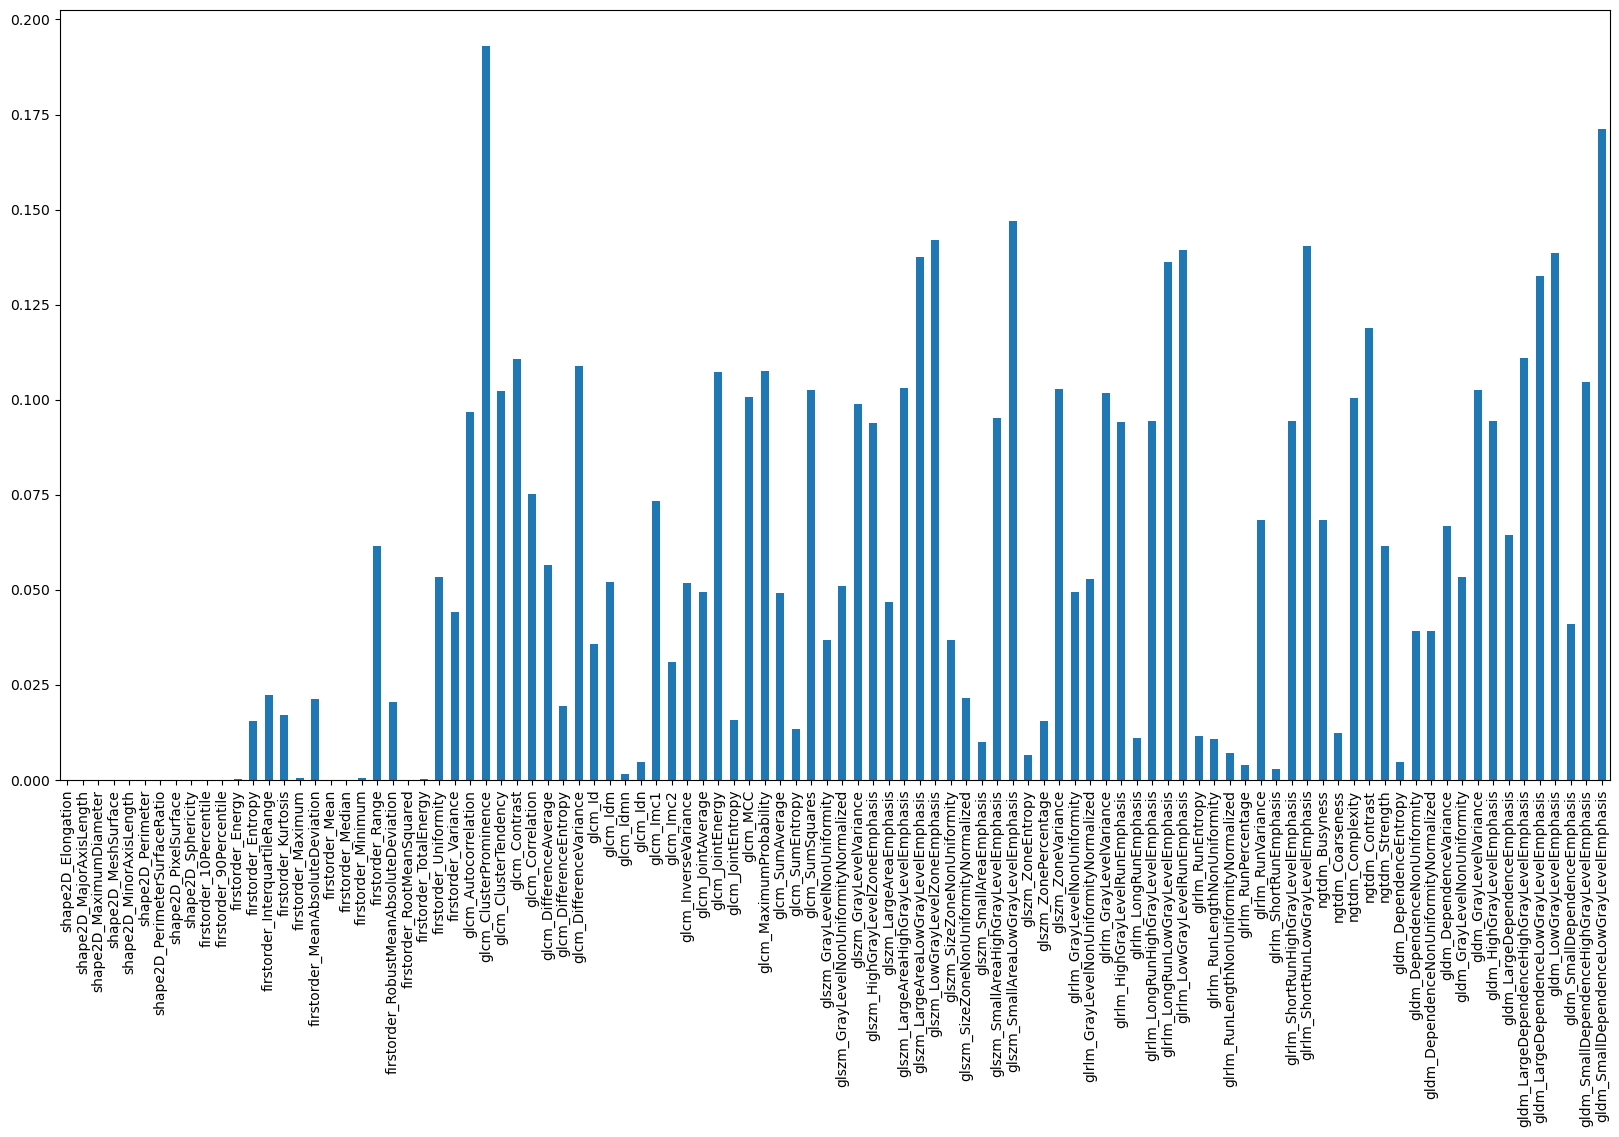

In [28]:
#basically, the mean of all rows
df_budget = df_cv.mean(axis=0)
#save as excel file
df_budget.to_excel(str(repo_path / 'data/budget/budget.xlsx'))
#we exclude element if the value is greater then 1
df_budget = abs(df_budget[df_budget < 1])
#finally, we plot the budget
df_budget.plot(kind='bar', figsize=(20,10))